In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision
import torchvision.transforms as transforms


In [64]:
# Define transformations
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),           # Resize and crop to 224x224
    transforms.RandomHorizontalFlip(),           # Randomly flip images
    transforms.RandomRotation(30),               # Randomly rotate images
    transforms.ToTensor(),                       # Convert images to PyTorch tensors
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])   # Normalize with ImageNet stats
])

# Load Flowers102 dataset
train_data = datasets.Flowers102(root='data', split='train', download=True, transform=transform)
val_data = datasets.Flowers102(root='data', split='val', download=True, transform=transform)
test_data = datasets.Flowers102(root='data', split='test', download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(test_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(train_data, batch_size=32, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


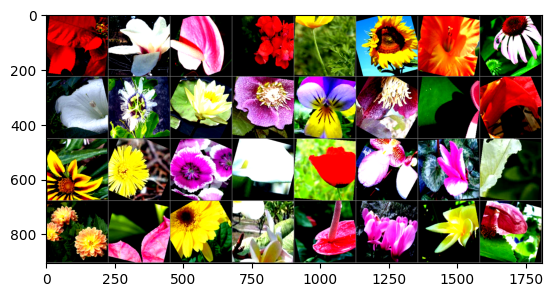

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [66]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print("[INFO] Current device:", torch.cuda.get_device_name(torch.cuda.current_device()), f", device num:{torch.cuda.current_device()}")
elif torch.has_mps:
    device = 'mps'
    print("[INFO] Current device: MAC OS Metal Performance Shaders.")
else:
    device = 'cpu'
    print("[INFO] Current device: CPU")
    print("*"*50,"\n[WARNING] You may need to change the device to GPU or MPS to get better performance.")
    print("*"*50)
device = torch.device(device)

[INFO] Current device: NVIDIA GeForce RTX 3090 Ti , device num:0


In [67]:
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, activation_fn=nn.ReLU):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.activation = activation_fn(inplace=True)  # Pass the activation function
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample  # Adjust dimensions if needed for skip connection

    def forward(self, x):
        identity = x  # Save the input for the skip connection

        # First convolutional layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)  # Apply chosen activation function

        # Second convolutional layer
        out = self.conv2(out)
        out = self.bn2(out)

        # Downsample the input if necessary
        if self.downsample is not None:
            identity = self.downsample(x)

        # Add skip connection (identity)
        out += identity
        out = self.activation(out)  # Apply chosen activation function

        return out


In [68]:
class CustomResNet(nn.Module):
    def __init__(self, block, layers, num_classes=102, activation_fn=nn.ReLU):
        super(CustomResNet, self).__init__()
        self.in_channels = 64  # Initial number of filters

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet layers (4 stages)
        self.layer1 = self._make_layer(block, 64, layers[0], activation_fn = activation_fn)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, activation_fn = activation_fn)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, activation_fn = activation_fn)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, activation_fn = activation_fn)

        # Global average pooling and fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)  # 102 classes for Flowers102

    def _make_layer(self, block, out_channels, blocks, stride=1, activation_fn=nn.ReLU):
        # Helper function to create a stage with several residual blocks
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample, activation_fn))
        self.in_channels = out_channels

        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        # Forward pass through the network
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


In [69]:
# Define the model using ResNet18 configuration (2 residual blocks per stage)
def custom_resnet18(num_classes=102, activation_fn=nn.ReLU):
    return CustomResNet(ResidualBlock, [2, 2, 2, 2], num_classes=num_classes, activation_fn=activation_fn)


In [70]:
def train_model(model, criterion, optimizer, num_epochs=10):
    lost_list = []
    accur_list = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        lost_list.append(epoch_loss)
        epoch_acc = 100 * correct / total
        accur_list.append(epoch_acc)
        if epoch % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

    return model, lost_list, accur_list


In [71]:
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    print(f'Accuracy: {acc:.2f}%')


In [72]:
# Initialize the model
model = custom_resnet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, weight_decay=0)


Epoch 1/300, Loss: 3.9993, Accuracy: 9.22%
Epoch 11/300, Loss: 2.1254, Accuracy: 43.08%
Epoch 21/300, Loss: 1.4559, Accuracy: 60.04%
Epoch 31/300, Loss: 1.0725, Accuracy: 69.80%
Epoch 41/300, Loss: 0.7839, Accuracy: 77.88%
Epoch 51/300, Loss: 0.6078, Accuracy: 83.40%
Epoch 61/300, Loss: 0.4756, Accuracy: 86.70%
Epoch 71/300, Loss: 0.4418, Accuracy: 87.45%
Epoch 81/300, Loss: 0.3670, Accuracy: 89.64%
Epoch 91/300, Loss: 0.3117, Accuracy: 91.07%
Epoch 101/300, Loss: 0.3027, Accuracy: 91.45%
Epoch 111/300, Loss: 0.2584, Accuracy: 92.75%
Epoch 121/300, Loss: 0.2598, Accuracy: 92.57%
Epoch 131/300, Loss: 0.2388, Accuracy: 93.35%
Epoch 141/300, Loss: 0.2205, Accuracy: 93.66%
Epoch 151/300, Loss: 0.2328, Accuracy: 93.54%
Epoch 161/300, Loss: 0.2210, Accuracy: 93.62%
Epoch 171/300, Loss: 0.1887, Accuracy: 94.71%
Epoch 181/300, Loss: 0.1550, Accuracy: 95.69%
Epoch 191/300, Loss: 0.1865, Accuracy: 94.89%
Epoch 201/300, Loss: 0.1724, Accuracy: 95.37%
Epoch 211/300, Loss: 0.1693, Accuracy: 95.45%


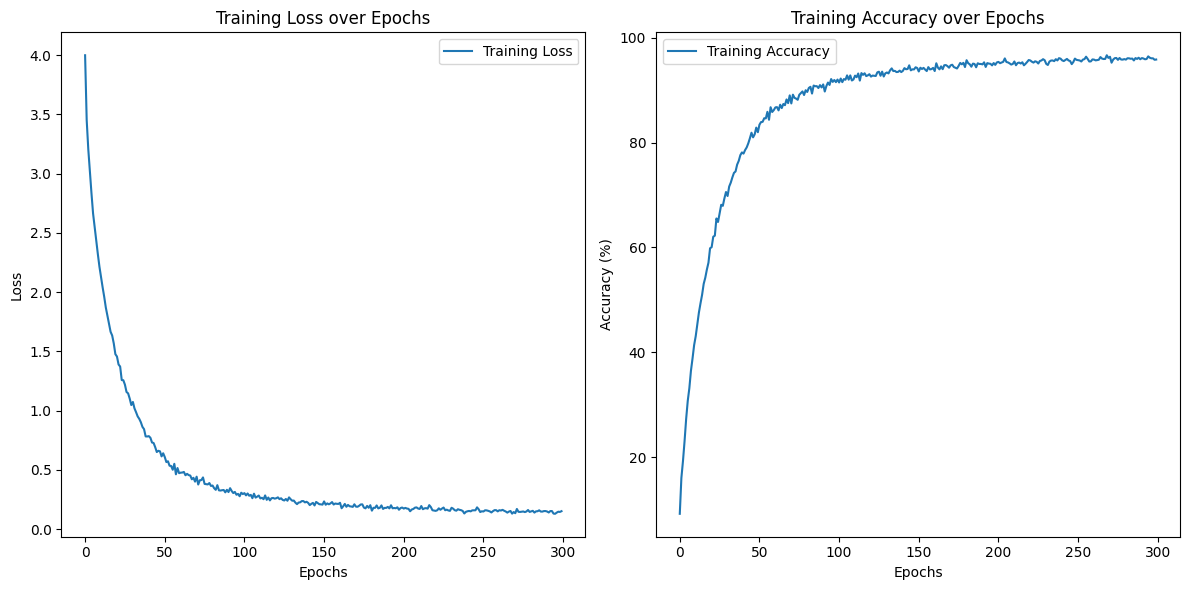

In [73]:
num_epochs = 300

# Initialize the model
model = custom_resnet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, weight_decay=0)
model, RELU_lost_list, RELU_acc_list = train_model(model, criterion, optimizer, num_epochs=num_epochs)


import matplotlib.pyplot as plt

# Validate the model
print("Validation Accuracy:")
evaluate_model(model, val_loader)

# Test the model (Optional)
print("Test Accuracy:")
evaluate_model(model, test_loader)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), RELU_lost_list, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), RELU_acc_list, label="Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/300, Loss: 4.0110, Accuracy: 8.91%
Epoch 11/300, Loss: 2.0878, Accuracy: 43.89%
Epoch 21/300, Loss: 1.4205, Accuracy: 61.38%
Epoch 31/300, Loss: 1.0097, Accuracy: 71.20%
Epoch 41/300, Loss: 0.7483, Accuracy: 79.17%
Epoch 51/300, Loss: 0.6011, Accuracy: 82.78%
Epoch 61/300, Loss: 0.4714, Accuracy: 86.36%
Epoch 71/300, Loss: 0.4228, Accuracy: 87.59%
Epoch 81/300, Loss: 0.3844, Accuracy: 89.14%
Epoch 91/300, Loss: 0.3235, Accuracy: 90.78%
Epoch 101/300, Loss: 0.3040, Accuracy: 91.38%
Epoch 111/300, Loss: 0.2588, Accuracy: 92.65%
Epoch 121/300, Loss: 0.2785, Accuracy: 92.28%
Epoch 131/300, Loss: 0.2440, Accuracy: 92.99%
Epoch 141/300, Loss: 0.2342, Accuracy: 93.28%
Epoch 151/300, Loss: 0.2277, Accuracy: 93.80%
Epoch 161/300, Loss: 0.2054, Accuracy: 94.08%
Epoch 171/300, Loss: 0.1848, Accuracy: 94.76%
Epoch 181/300, Loss: 0.1883, Accuracy: 94.75%
Epoch 191/300, Loss: 0.1772, Accuracy: 94.76%
Epoch 201/300, Loss: 0.1698, Accuracy: 95.19%
Epoch 211/300, Loss: 0.1739, Accuracy: 95.54%


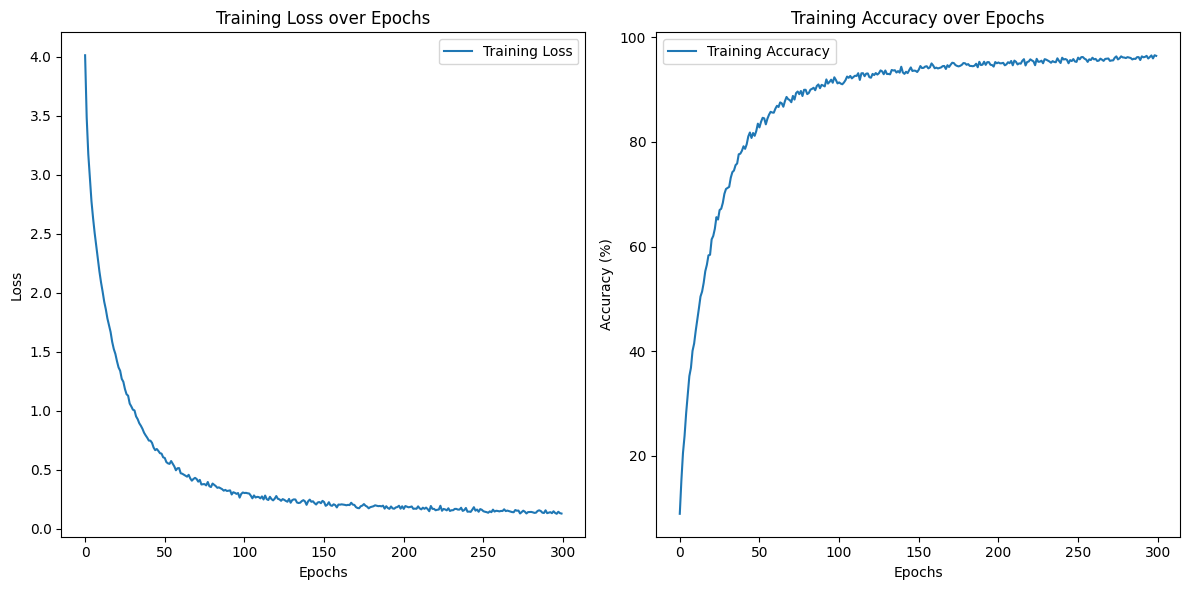

In [74]:
num_epochs = 300

# Initialize the model
model = custom_resnet18(activation_fn=nn.LeakyReLU).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, weight_decay=0)
model, RELU_lost_list, RELU_acc_list = train_model(model, criterion, optimizer, num_epochs=num_epochs)


import matplotlib.pyplot as plt

# Validate the model
print("Validation Accuracy:")
evaluate_model(model, val_loader)

# Test the model (Optional)
print("Test Accuracy:")
evaluate_model(model, test_loader)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), RELU_lost_list, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), RELU_acc_list, label="Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/300, Loss: 4.0234, Accuracy: 8.62%
Epoch 11/300, Loss: 2.1322, Accuracy: 43.41%
Epoch 21/300, Loss: 1.5415, Accuracy: 58.07%
Epoch 31/300, Loss: 1.1488, Accuracy: 67.85%
Epoch 41/300, Loss: 0.8747, Accuracy: 75.59%
Epoch 51/300, Loss: 0.6556, Accuracy: 81.15%
Epoch 61/300, Loss: 0.5605, Accuracy: 84.01%
Epoch 71/300, Loss: 0.4329, Accuracy: 87.66%
Epoch 81/300, Loss: 0.4129, Accuracy: 88.79%
Epoch 91/300, Loss: 0.3499, Accuracy: 90.00%
Epoch 101/300, Loss: 0.3410, Accuracy: 90.62%
Epoch 111/300, Loss: 0.2987, Accuracy: 91.62%
Epoch 121/300, Loss: 0.2802, Accuracy: 91.87%
Epoch 131/300, Loss: 0.2626, Accuracy: 92.55%
Epoch 141/300, Loss: 0.2240, Accuracy: 93.76%
Epoch 151/300, Loss: 0.2473, Accuracy: 92.99%
Epoch 161/300, Loss: 0.2195, Accuracy: 93.80%
Epoch 171/300, Loss: 0.2174, Accuracy: 93.59%
Epoch 181/300, Loss: 0.1977, Accuracy: 94.41%
Epoch 191/300, Loss: 0.2059, Accuracy: 94.11%
Epoch 201/300, Loss: 0.1840, Accuracy: 94.68%
Epoch 211/300, Loss: 0.1968, Accuracy: 94.41%


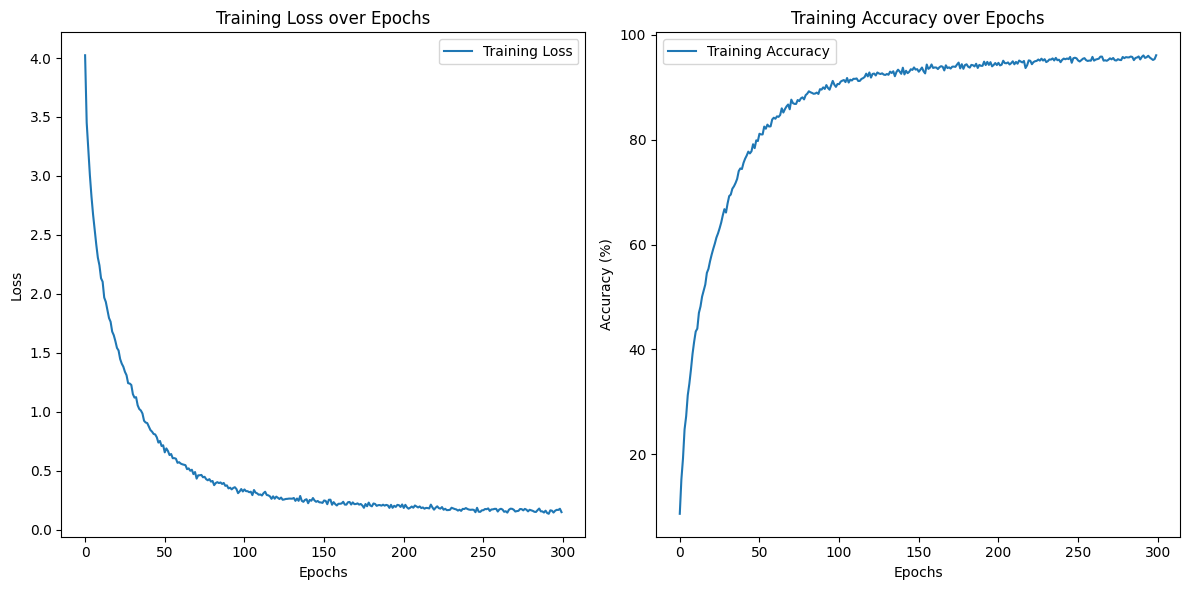

In [75]:
num_epochs = 300

# Initialize the model
model = custom_resnet18(activation_fn=nn.ELU).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, weight_decay=0)
model, RELU_lost_list, RELU_acc_list = train_model(model, criterion, optimizer, num_epochs=num_epochs)


import matplotlib.pyplot as plt

# Validate the model
print("Validation Accuracy:")
evaluate_model(model, val_loader)

# Test the model (Optional)
print("Test Accuracy:")
evaluate_model(model, test_loader)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), RELU_lost_list, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), RELU_acc_list, label="Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

In [76]:
# Save the trained model
torch.save(model.state_dict(), 'custom_resnet18_flowers102.pth')
